In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.math import confusion_matrix
from tensorflow.keras.losses import BinaryCrossentropy

from keras.models import Sequential
from keras.layers import Embedding, TextVectorization, Input, Dense, LSTM, Bidirectional, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib import pyplot as plt


gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
data = pd.read_csv("data/data_merged.csv")
len(data)

58671

<AxesSubplot:ylabel='class'>

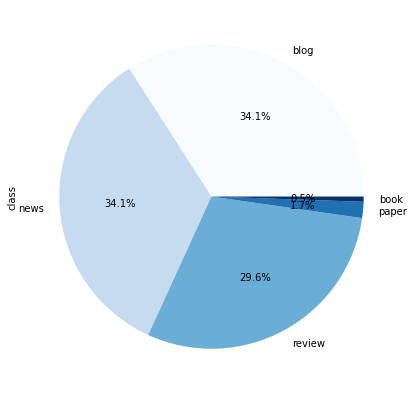

In [23]:
data["class"].value_counts().plot.pie(cmap=plt.cm.Blues, figsize=(7, 7), autopct="%1.1f%%")

Todo: Ungleichverteilung auflösen -> mehr Samples für Bücher und wiss. Paper

In [5]:
data = data.dropna(how="any", axis=0)
len(data)

58668

In [16]:
pd.get_dummies(data["class"]).head(5)

,blog,book,news,paper,review
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [4]:
data.sample(5)

,text,class
594,Photo by Mikael Seegen on Unsplash\n\nEach cig...,blog
44674,i used it for about month and then the sensor ...,review
1010,"A stinky game in the Bronx, an interesting one...",blog
3649,Bridging the gap between fundamental research ...,blog
16853,Attn: Business Owners.\n\n\n\nThe ongoing coro...,blog


In [6]:
X = data["text"]
y = pd.get_dummies(data["class"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [7]:
max_tokens = 10000
sequence_len = 256

vectorization_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_len)
vectorization_layer.adapt(X_train)

In [8]:
model = Sequential([
    Input(dtype=tf.string, shape=1),
    vectorization_layer,
    Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=256, mask_zero=True),
    Bidirectional(LSTM(512, return_sequences=True)),
    Dropout(0.03),
    Bidirectional(LSTM(256, return_sequences=True)),
    LSTM(64),
    Dense(5, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 256)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 1024)        3149824   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 512)         2623488   
 nal)                                                            
                                                        

In [9]:
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

In [10]:
history = model.fit(X_train, y_train, epochs=4, validation_split=0.15)

Epoch 1/10
1247/1247 [==============================] - 983s 772ms/step - loss: 0.1408 - accuracy: 0.8737 - val_loss: 0.0949 - val_accuracy: 0.9328
Epoch 2/10
1247/1247 [==============================] - 932s 748ms/step - loss: 0.0651 - accuracy: 0.9521 - val_loss: 0.0488 - val_accuracy: 0.9601
Epoch 3/10
1247/1247 [==============================] - 969s 778ms/step - loss: 0.0341 - accuracy: 0.9748 - val_loss: 0.0348 - val_accuracy: 0.9754
Epoch 4/10
1247/1247 [==============================] - 952s 764ms/step - loss: 0.0220 - accuracy: 0.9841 - val_loss: 0.0848 - val_accuracy: 0.9395
Epoch 5/10
1247/1247 [==============================] - 942s 756ms/step - loss: 0.0169 - accuracy: 0.9874 - val_loss: 0.0277 - val_accuracy: 0.9800
Epoch 6/10
1247/1247 [==============================] - 940s 754ms/step - loss: 0.0190 - accuracy: 0.9863 - val_loss: 0.0280 - val_accuracy: 0.9794
Epoch 7/10
1247/1247 [==============================] - 935s 751ms/step - loss: 0.0101 - accuracy: 0.9923 - val_

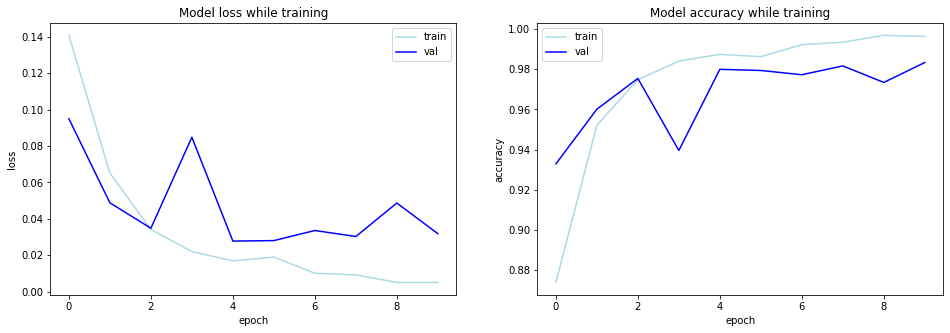

In [25]:
fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history.history["loss"], color="lightblue")
plt.plot(history.history["val_loss"], color="blue")
plt.title("Model loss while training")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"])

fig.add_subplot(1, 2, 2)
plt.plot(history.history["accuracy"], color="lightblue")
plt.plot(history.history["val_accuracy"], color="blue")
plt.title("Model accuracy while training")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"])
plt.show()

Trainingsdauer: 155 Minuten, 4GB VRAM, 10 Epochen

In [12]:
model.save("models/classification_rnn_1.0")

INFO:tensorflow:Assets written to: models/rnn_1.0\assets


INFO:tensorflow:Assets written to: models/rnn_1.0\assets


In [13]:
accuracy = model.evaluate(X_test, y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.02697935700416565, 0.983552098274231]


In [16]:
y_pred = model.predict(X_test)
y_pred_int = np.round(y_pred)

confusion = confusion_matrix(labels=y_test.to_numpy().argmax(axis=1), predictions=y_pred_int.argmax(axis=1))

367/367 [==============================] - 39s 105ms/step


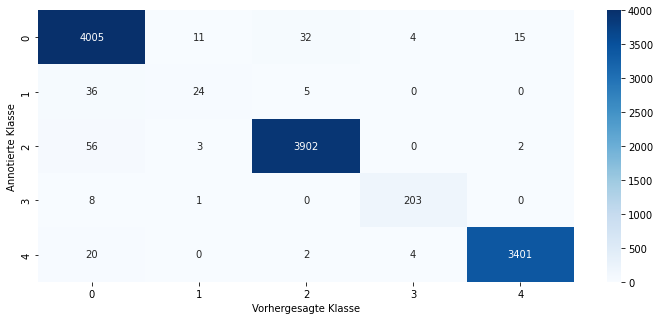

In [17]:
plt.figure(figsize=(12,5))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues)

plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Annotierte Klasse")
plt.show()

In [31]:
y_test_max = y_test.to_numpy().argmax(axis=1)
y_pred_max = y_pred_int.argmax(axis=1)

print("Test Recall:", recall_score(y_test_max, y_pred_max, average="weighted"))
print("Test Precision:", precision_score(y_test_max, y_pred_max, average="weighted"))
print("Test F1-Score:", f1_score(y_test_max, y_pred_max, average="weighted"))

Test Recall: 0.9830407363217999
Test Precision: 0.9823067056225686
Test F1-Score: 0.9824831049682028


| Dummy Variable | Klasse |
|---|---|
| 0 | Blog |
| 1 | Buch |
| 2 | News |
| 3 | Paper |
| 4 | Review |

In [47]:
example_input = """
the book was in perfect condition and i enjoyed it a lot!
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 82ms/step
[[2.1599231e-05 6.4005467e-06 4.4313896e-05 2.9180035e-06 9.9995148e-01]]
[4]


In [50]:
example_input = """
Air quality concerns continue as Canadian wildfire smoke covers the Northeast
The smoke in major metro areas, including New York, Boston, Philadelphia and Washington, D.C., was expected to cause unhealthy air for all groups.
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 47ms/step
[[7.8828093e-03 2.4914127e-04 9.9281293e-01 1.7458398e-05 8.5420434e-05]]
[2]


In [53]:
example_input = """
One of the most expensive aspects of any cybercriminal operation is the time and effort it takes to constantly create large numbers of new throwaway email accounts. 
Now a new service offers to help dramatically cut costs associated with large-scale spam and account creation campaigns, by paying people to sell their email account credentials 
and letting customers temporarily rent access to a vast pool of established accounts at major providers.
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 152ms/step
[[9.3282437e-01 1.2088064e-03 6.8079419e-02 6.6798616e-06 8.4219326e-05]]
[0]


In [52]:
example_input = """
We propose and implement an interpretable machine learning classification model for Explainable AI (XAI) based on expressive Boolean formulas. 
Potential applications include credit scoring and diagnosis of medical conditions. The Boolean formula defines a rule with tunable complexity (or interpretability), 
according to which input data are classified. Such a formula can include any operator that can be applied to one or more Boolean variables, thus providing higher expressivity 
compared to more rigid rule-based and tree-based approaches. The classifier is trained using native local optimization techniques, efficiently searching the space of feasible formulas. 
Shallow rules can be determined by fast Integer Linear Programming (ILP) or Quadratic Unconstrained Binary Optimization (QUBO) solvers, potentially powered by special purpose hardware or quantum devices.
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 198ms/step
[[9.0191578e-03 7.7632606e-02 9.0522490e-02 3.1605318e-01 2.7173874e-04]]
[3]
